In [54]:
import pandas as pd
import ruptures as rpt
import numpy as np
import os
import function.DataFunction as dt
import function.visualise as vs
from sklearn.model_selection import  GridSearchCV, cross_val_score
from sklearn.svm import SVC
import joblib

In [23]:
dtf = dt.DataFunction()
vi = vs.Visualise()

In [24]:
def setLabel(fallPath: str, normalPath: str) -> np.array:
    label = []
    for file in os.listdir(fallPath):
        df = pd.read_csv(fallPath + file)
        diff = df[df.columns[1::2]]
        algo1 = rpt.Pelt(model="rbf").fit(diff.iloc[:,0].to_numpy())
        fluctuation = algo1.predict(pen=10)
        for i in range(len(df)):
            if i < fluctuation[0]:
                label.append(-1)
            else:
                label.append(1)
    for file in os.listdir(normalPath):
        df = pd.read_csv(normalPath + file)
        for i in range(len(df)):
            label.append(-1)
    return np.array(label)

In [55]:
path =  'C://python//train//'
fallPath = 'C://python//train//fall_csv_new_test//'
normalPath = 'C://python//train//normal_csv_new_test//'

In [26]:
label = setLabel('C://python//train//fall_csv_new_test//', 'C://python//train//normal_csv_new_test//')

In [27]:
label, label.shape

(array([-1, -1, -1, ..., -1, -1, -1]), (8774,))

In [28]:
rawFallData = pd.concat([pd.read_csv(fallPath + file) for file in os.listdir(fallPath)])
rawNormalData = pd.concat([pd.read_csv(normalPath + file) for file in os.listdir(normalPath)]) 

In [29]:
data = np.concatenate((rawFallData, rawNormalData), axis=0)

In [30]:
label.shape, data.shape

((8774,), (8774, 30))

In [31]:
indices = np.arange(label.shape[0])

In [32]:
np.random.shuffle(indices)

In [33]:
data, label = data[indices], label[indices]

In [34]:
data, label = dtf.balanceTrainData(data, label)

In [35]:
x_train, x_test, x_val, y_train, y_test, y_val = dtf.splitData(data, label)

In [36]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((9177, 30), (3060, 30), (3059, 30), (9177,), (3060,), (3059,))

In [37]:
y_train[y_train == 1].shape, y_train[y_train == -1].shape

((4588,), (4589,))

In [38]:
y_test[y_test == 1].shape, y_test[y_test == -1].shape

((1535,), (1525,))

In [39]:
y_val[y_val == 1].shape, y_val[y_val == -1].shape

((1525,), (1534,))

In [41]:
def model_grid():
    param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
    return grid

In [44]:
model = model_grid()
model.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [51]:
model.best_estimator_

SVC(C=10, gamma=1, kernel='poly')

In [45]:
def validate(x_val, y_val, model):
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    for score in scoring:
        scores = cross_val_score(model, x_val, y_val, cv=10, scoring=score)
        print(score, scores.mean())

In [46]:
validate(x_val, y_val, model.best_estimator_)

accuracy 0.9728651023250832
precision_macro 0.9730765230887382
recall_macro 0.9728944967141562
f1_macro 0.972862477836974


In [47]:
y_pred = model.predict(x_test)

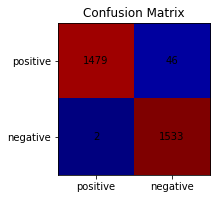

In [48]:
vi.conf_mat(y_test, y_pred)

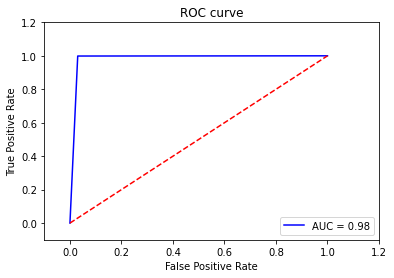

In [49]:
vi.show_roc(y_test, y_pred)

In [50]:
vi.report(y_test, y_pred)

              precision    recall  f1-score   support

          -1       1.00      0.97      0.98      1525
           1       0.97      1.00      0.98      1535

    accuracy                           0.98      3060
   macro avg       0.98      0.98      0.98      3060
weighted avg       0.98      0.98      0.98      3060



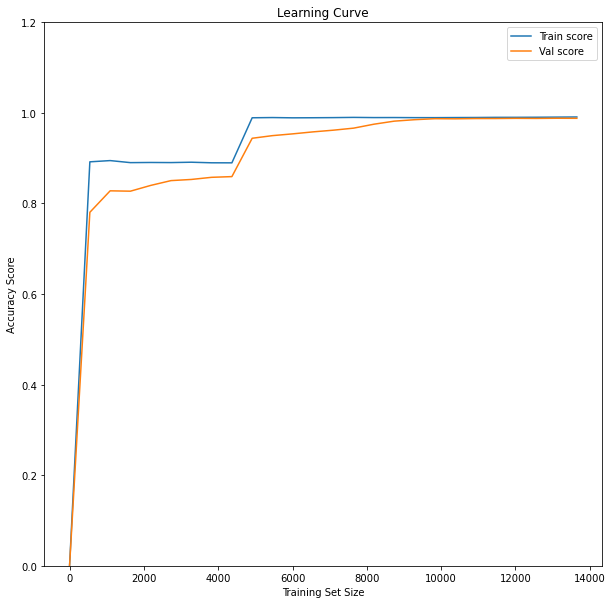

In [53]:
vi.learning_curve_plot(data, label, model.best_estimator_)

In [56]:
joblib.dump(model.best_estimator_, path + 'model_final//model_new_data.sav')

['C://python//train//model_final//model_new_data.sav']